In [ ]:
from google.colab import drive
drive.mount("/content/gdrive", force_remount=True)

Mounted at /content/gdrive


In [ ]:

!wget "https://www.kaggle.com/api/v1/datasets/download/eoussama/breast-cancer-mammograms"
!unzip /content/breast-cancer-mammograms -d dataset

Streaming output truncated to the last 5000 lines.
  inflating: dataset/malignant/20586986 (47).png  
  inflating: dataset/malignant/20586986 (48).png  
  inflating: dataset/malignant/20586986 (49).png  
  inflating: dataset/malignant/20586986 (5).png  
  inflating: dataset/malignant/20586986 (50).png  
  inflating: dataset/malignant/20586986 (51).png  
  inflating: dataset/malignant/20586986 (52).png  
  inflating: dataset/malignant/20586986 (53).png  
  inflating: dataset/malignant/20586986 (54).png  
  inflating: dataset/malignant/20586986 (55).png  
  inflating: dataset/malignant/20586986 (56).png  
  inflating: dataset/malignant/20586986 (57).png  
  inflating: dataset/malignant/20586986 (58).png  
  inflating: dataset/malignant/20586986 (59).png  
  inflating: dataset/malignant/20586986 (6).png  
  inflating: dataset/malignant/20586986 (60).png  
  inflating: dataset/malignant/20586986 (61).png  
  inflating: dataset/malignant/20586986 (62).png  
  inflating: dataset/malignant/20

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np

import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten , Dropout , BatchNormalization, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import Callback, ModelCheckpoint, CSVLogger

import pickle

from sklearn.metrics import classification_report,confusion_matrix

In [ ]:
datagen = ImageDataGenerator(rescale = 1./255)

In [ ]:
import os
import shutil
import random

def split_data(source_dir, output_dir, train_ratio=0.7, val_ratio=0.15):
    categories = ['benign', 'malignant']

    for split in ['train', 'validation', 'test']:
        for category in categories:
            os.makedirs(os.path.join(output_dir, split, category), exist_ok=True)

    for category in categories:
        files = os.listdir(os.path.join(source_dir, category))
        random.shuffle(files)

        train_size = int(len(files) * train_ratio)
        val_size = int(len(files) * val_ratio)

        datasets = {
            'train': files[:train_size],
            'validation': files[train_size:train_size + val_size],
            'test': files[train_size + val_size:]
        }

        for split, images in datasets.items():
            for img in images:
                shutil.copy(
                    os.path.join(source_dir, category, img),
                    os.path.join(output_dir, split, category, img)
                )

source_directory = "/content/dataset"
output_directory = "source_directory"
split_data(source_directory, output_directory)


In [ ]:
train = datagen.flow_from_directory('/content/source_directory/train/', target_size=(224, 224), class_mode='binary', batch_size=64)
# load and iterate validation dataset
val = datagen.flow_from_directory('/content/source_directory/validation/', target_size=(224, 224), class_mode='binary', batch_size=64)
# load and iterate test dataset
test = datagen.flow_from_directory('/content/source_directory/test/', target_size=(224, 224), class_mode='binary', batch_size=64)

Found 5342 images belonging to 2 classes.
Found 1144 images belonging to 2 classes.
Found 1146 images belonging to 2 classes.


In [ ]:
imgs, labels = next(train)
print(imgs.shape)
train.class_indices

(64, 224, 224, 3)


{'benign': 0, 'malignant': 1}

1.0


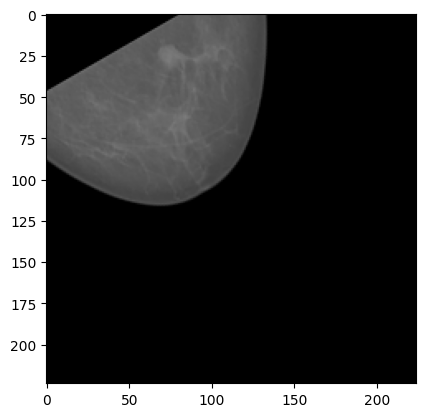

In [ ]:
plt.imshow(imgs[0])
print(labels[0])


In [ ]:
model = Sequential()
model.add(Conv2D(64, (3, 3), input_shape=(224,224,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.6))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 222, 222, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 111, 111, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 109, 109, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 54, 54, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 52, 52, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 26, 26, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 43264)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │       2,768,960 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,844,673 (10.85 MB)

 Trainable params: 2,844,673 (10.85 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
STEP_SIZE_TRAIN = train.n//train.batch_size
STEP_SIZE_VAL = val.n//val.batch_size

In [ ]:
csv_logger = CSVLogger('/content/gdrive/My Drive/training.log', separator=',', append=False)

history = model.fit(
    train,
    steps_per_epoch=STEP_SIZE_TRAIN,
    validation_data=test,
    validation_steps=STEP_SIZE_VAL,
    epochs=40,
    callbacks=[csv_logger]
)


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/40
83/83 ━━━━━━━━━━━━━━━━━━━━ 32s 262ms/step - accuracy: 0.6317 - loss: 0.6770 - val_accuracy: 0.6728 - val_loss: 0.6284
Epoch 2/40
 1/83 ━━━━━━━━━━━━━━━━━━━━ 9s 115ms/step - accuracy: 0.6562 - loss: 0.6242

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.6562 - loss: 0.6242 - val_accuracy: 0.6746 - val_loss: 0.6262
Epoch 3/40
83/83 ━━━━━━━━━━━━━━━━━━━━ 22s 165ms/step - accuracy: 0.6671 - loss: 0.6444 - val_accuracy: 0.6654 - val_loss: 0.6325
Epoch 4/40
83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.5938 - loss: 0.6771 - val_accuracy: 0.6719 - val_loss: 0.6337
Epoch 5/40
83/83 ━━━━━━━━━━━━━━━━━━━━ 21s 199ms/step - accuracy: 0.6697 - loss: 0.6336 - val_accuracy: 0.6636 - val_loss: 0.6300
Epoch 6/40
83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - accuracy: 0.6562 - loss: 0.6127 - val_accuracy: 0.6700 - val_loss: 0.6247
Epoch 7/40
83/83 ━━━━━━━━━━━━━━━━━━━━ 14s 166ms/step - accuracy: 0.6694 - loss: 0.6324 - val_accuracy: 0.6700 - val_loss: 0.6227
Epoch 8/40
83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - accuracy: 0.5938 - loss: 0.6452 - val_accuracy: 0.6719 - val_loss: 0.6230
Epoch 9/40
83/83 ━━━━━━━━━━━━━━━━━━━━ 14s 170ms/step - accuracy: 0.6696 - loss: 0.6235 - val_accuracy: 0.6673 - val_

18/18 ━━━━━━━━━━━━━━━━━━━━ 5s 271ms/step - accuracy: 0.9544 - loss: 0.1417
Test Loss: 0.14729565382003784
Test Accuracy: 0.9528796076774597


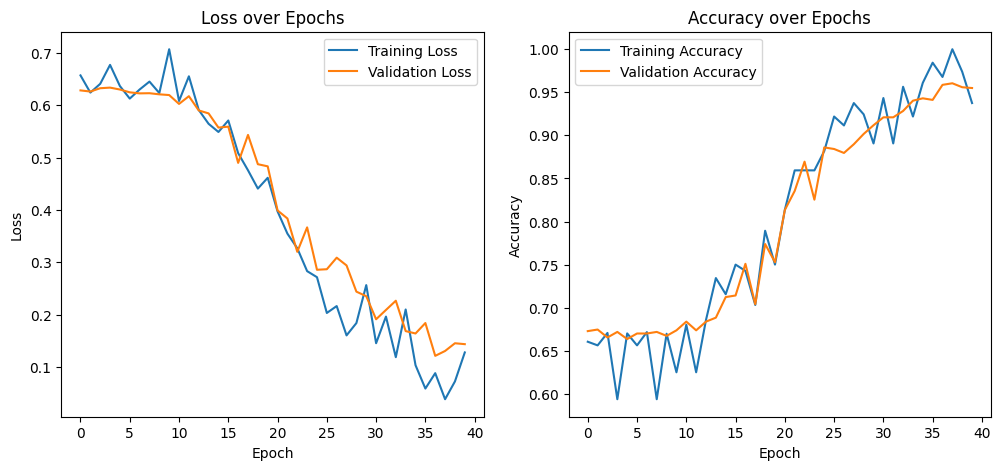

Model architecture saved as 'model_architecture.png'.


In [ ]:
#           ------    VIUALIZATION    ------

from tensorflow.keras.utils import plot_model

test_loss, test_accuracy = model.evaluate(test, steps=len(test) // 64)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss over Epochs')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy over Epochs')
plt.legend()

plt.show()

plot_model(model, to_file='new_model_architecture.png', show_shapes=True, show_layer_names=True)
print("Model architecture saved as 'model_architecture.png'.")

In [ ]:
model.save('/content/gdrive/My Drive/BreastCancer95%_model.h5')

In [ ]:
print(classification_report(y_test, y_pred, target_names = ['Benign (Class 0)','Malignant (Class 1)']))